In [6]:
import torch 
from torch import nn, optim
import torchvision 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 
import math 
import numpy as np
from PIL import Image
import cv2
from tqdm.notebook import tqdm 
from functools import partial

In [7]:
class DigitRecognizer(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes):
        super(DigitRecognizer, self).__init__()
        self.input = nn.Linear(input_size, hidden_sizes[0])
        self.relu_0 = nn.ReLU()
        self.hidden1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu_1 = nn.ReLU()
        self.output = nn.Linear(hidden_sizes[1], num_classes)
        
    def forward(self, X):
        model = self.input(X)
        model = self.relu_0(model)
        model = self.hidden1(model)
        model = self.relu_1(model)
        model = self.output(model)
        return model 

In [8]:
batch_size = 50
#transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)),])
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST('./', download=True, train=True, transform=transform)
test_data = datasets.MNIST('./', download=True, train=False, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False , num_workers=2)

In [13]:
model = torch.load('digit_classifier.pt')
model.eval()

DigitRecognizer(
  (input): Linear(in_features=784, out_features=128, bias=True)
  (relu_0): ReLU()
  (hidden1): Linear(in_features=128, out_features=64, bias=True)
  (relu_1): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
)

In [339]:
epsilon_upper = 0 
def eval_model(model, images):
    images = images.astype(np.float32)
    images = torch.from_numpy(images)
    images = images.reshape(-1, 784)
    outputs = model(images) 
    _, test_predicted = torch.max(outputs.data,1)
    return test_predicted.item()

def is_adversarial(oracle, target_class, image): 
    if oracle(image) != target_class: 
        return True 
    return False

def initial_adversarial(target_, advesarial_criterion):
    while True: 
        random_pertubation = np.random.uniform(0,255,size = (28,28)).astype(np.float32)
        if advesarial_criterion(random_pertubation): 
            return random_pertubation
    
def step_towards(target_, pertubation, epsilon):
    pertubation -= ((pertubation - target_) * epsilon)
    return pertubation
    
def orthogonal_pertubation(target_, pertubation, delta): 
    # iid random normal 
    new_pertubation = np.random.normal(0,1,size=(28,28))
    new_pertubation /= np.linalg.norm(new_pertubation)
    # || n_k||^2 = delta * dist(previous_adversarial, original_image), condition 2 
    new_pertubation *= delta * np.linalg.norm(pertubation - target_)
    new_pertubation += pertubation
    # condition 1
    new_pertubation = new_pertubation.clip(0,255)
    #projecting onto sphere 
    new_pertubation -= target_
    new_pertubation /= np.linalg.norm(new_pertubation)
    new_pertubation *= np.linalg.norm(pertubation - target_)
    new_pertubation += target_
    return new_pertubation
    
def adaptive_delta_descent(is_adversarial_fn, side_step_fn, adversarial_img): 
    lower_delta =1
    upper_delta = 0
    delta = -1
    while True: 
   # while abs(delta - upper_delta) > .01: 
        delta = (lower_delta + upper_delta)/2
        random_side_steps = [side_step_fn(adversarial_img, delta) \
                 for i in range(10)]
        adversarial_indices = [is_adversarial_fn(x) for x in random_side_steps]
        average = np.mean(adversarial_indices)
        #print(f'{average=}')
        #print(f'{delta=}')
        if abs(average - .5) <= .05: 
            break
        elif average > .55:
            upper_delta = delta #increasing delta 
        else:  # average < .45
            lower_delta = delta # decreasing delta
            
    indices = np.where(np.array(adversarial_indices) == True)[0]
    return np.array(random_side_steps)[indices]
    
def adaptive_epsilon_descent(target, is_adversarial_fn, adversarial_img): 
    global epsilon_upper
    epsilon_lower = 1
    epsilon_upper = 0
    epsilon = (epsilon_lower + epsilon_upper)/2

    while epsilon_upper == 0 or abs(epsilon - epsilon_upper) > .0001: 
        epsilon = (epsilon_lower + epsilon_upper)/2
        new_pertubation = adversarial_img - ((adversarial_img - target) * epsilon)
        if is_adversarial_fn(new_pertubation):
            epsilon_upper = epsilon
        else: 
            epsilon_lower = epsilon
    new_pertubation = adversarial_img - ((adversarial_img - target) * epsilon_upper)
    return new_pertubation
    
def minimum_distance_img(target, imgs):
    min_ = float('inf')
    index = 0
    for step, x in enumerate(imgs): 
        dist = np.linalg.norm(x - min_)
        if dist < min_: 
            min_ = dist
            index = step
    return imgs[index] 
            
    
def boundary_attack(model, oracle, target_, target_class, k):
    global epsilon_upper
    #create partials so to avoid passing in same parameters every time 
    # step_towards_(pertubation, epsilon)
    step_towards_= partial(step_towards, target_) 
    # oracle_(images)
    oracle_ = partial(oracle, model) 
    #is_adversarial_(image)
    is_adversarial_ = partial(is_adversarial, oracle_, target_class) 
    #orthogonal_pertubation_(pertubation, delta)
    orthogonal_pertubation_ = partial(orthogonal_pertubation, target_)
    #adaptive_epsilon_descent_(pertubation)
    adaptive_epsilon_descent_ = partial(adaptive_epsilon_descent, target_, is_adversarial_)
    #adaptive_delta_descent_(pertubation)
    adaptive_delta_descent_ = partial(adaptive_delta_descent, is_adversarial_, \
                                      orthogonal_pertubation_)
    #min_dist_img_(images)
    min_dist_img_ = partial(minimum_distance_img, target_ )
    # initial adversarial
    adversarial_img = initial_adversarial(target_, oracle_)
    
    plt.imshow(adversarial_img, cmap="gray")
    plt.show()
    
    # initial descent
    adversarial_img = adaptive_epsilon_descent_(adversarial_img)
    
    plt.imshow(adversarial_img, cmap="gray")
    plt.show()

    count = 0
   # count_delta = 0
    for i in tqdm(range(k)): 
        #orthogonal step
        temp_adversarial_imgs  = adaptive_delta_descent_(adversarial_img)
        # downwards step 
        temp_adversarial_imgs = np.array([adaptive_epsilon_descent_(x) for\
                                          x in temp_adversarial_imgs], dtype = np.float64)
        
        temp_adversarial_imgs1 = [x for x in temp_adversarial_imgs if is_adversarial_(x)]
        
        if temp_adversarial_imgs1: # if list is not empty 
            adversarial_img = min_dist_img_(temp_adversarial_imgs1)
            #adversarial_img = temp_adversarial_imgs1[0]
            count += 1
    plt.imshow(adversarial_img, cmap="gray")
    plt.show()
    return adversarial_img
    

In [340]:
def return_target_img(class_num, num): 
    temp = []
    for a, b in train_data: 
        if b == class_num: 
            temp.append(a)
        if len(temp)==num: 
            return temp 
        

In [341]:
target = return_target_img(5, 1)[0] * 255

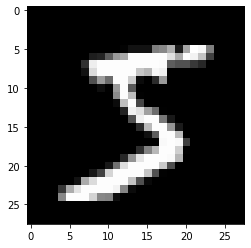

target_class=5


In [342]:
%matplotlib inline 
target = target.numpy().reshape((28,28))
target = target.astype(np.float32)
plt.imshow(target, cmap="gray")
plt.show()
target_class = eval_model(model, target)
print(f'{target_class=}')

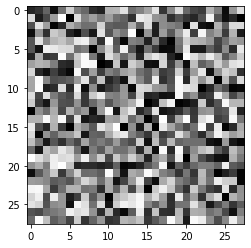

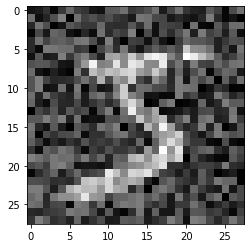

  0%|          | 0/1000 [00:00<?, ?it/s]

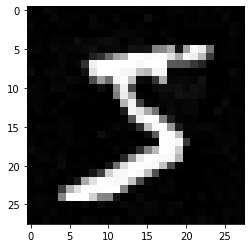

In [343]:
final = boundary_attack(model, eval_model, target, target_class, 1000)

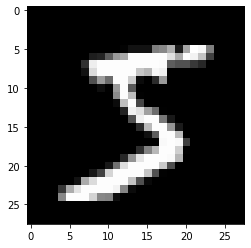

Image class: 5


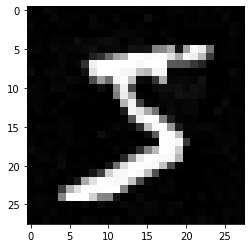

Adversarial class: 3 



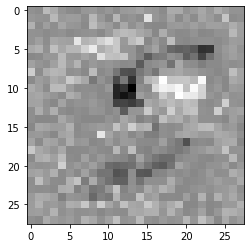

L2 norm between images: 133.40823197347692


In [344]:
%matplotlib inline 

plt.imshow(target, cmap="gray")
plt.show()
print(f'Image class: {eval_model(model, target)}')

 
plt.imshow(final, cmap="gray")
plt.show()
print(f'Adversarial class: {eval_model(model, final)} \n')


plt.imshow(final - target, cmap="gray")
plt.show()
print(f'L2 norm between images: {np.linalg.norm(final -  target) }')
